In [2]:
import numpy as np
from qiskit import QuantumCircuit, transpile, assemble, BasicAer, Aer, QuantumRegister
from qiskit.quantum_info import Statevector
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import plot_histogram, array_to_latex


# IICQ Project

The goal of this project is to show how to build quantum circuits using qiskit.

The first step is let people what Qiskit is and how to actually acess it (this is a python library yada yada yada) - Only done in ppt

The second step is to actually show how you can manipulate the basic properties of the circuit:

- How to initialize the register (all in littleEndian but clarify it can be changed)
- How to initialize the state
- How to acess the state vector  
- How to make controlled gates (littleEndian)
- How to measure
- How to simulate the circuit 
- How to draw

The third step is to show some known algorithms in Qiskit

- Grover's or Deutsche-Jostza or both (this is good practice for the test)
- Maybe even some cryptographic protocol! (No theory, just for show remember this is 15 mins)

## Initialization

- Use QuantumRegister(n) and ClassicalRegister(k), this way you can actually acess the qubits and bits. Then use QuantumCircuit(n, k)
- By default each qubit is set to the set $\ket{0}$.
- You can initialize the qubits by labelling with a string (e.g '001') or by using a list separated by commas. This values in this list are the scalars for the basis vectors. Be mindful of littleEndian!

We give some ordering examples:

- For a two-qubit system: $\ket{00} \ket{01} \ket{10} \ket{11}$

- For a three-qubit system : $\ket{000} \ket{001} \ket{010} \ket{011} \ket{100} \ket{101} \ket{110} \ket{111}$

In [3]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

In [4]:
# Helps with initialization. Default 0 since we might not need a classical register.
def quantum_initialization(n, k = 0):
    q = QuantumRegister(n)
    c = ClassicalRegister(k)

    qc = QuantumCircuit(n, k)

    return q, c, qc

In [5]:
# Initialization
q, c, qc = quantum_initialization(3)

qc.initialize([1, 0, 0, 0, 0, 0, 0, 0], qc.qubits)

st0 = Statevector(qc)
st0.draw(output='latex')

<IPython.core.display.Latex object>

In [6]:
qc.initialize('000', qc.qubits)

st0 = Statevector(qc)
st0.draw(output='latex')

<IPython.core.display.Latex object>

## Making Gates

Now that we know how to initialize our state lets try to make a very simple gate. For example, let's look at the Flip Operator (from PSET9)

The circuit is composed of three qubits and five gates: 4 X gates and 1 CCZ gate

To make the gates we just need to type qc."gate"("index of qubit"). If this gate is controlled we first arguments are the control qubits and the last is the target qubit.

The X gates are acting on the second and third qubit.

The CCZ gate acts on the first qubit.

We write the circuit from left to right

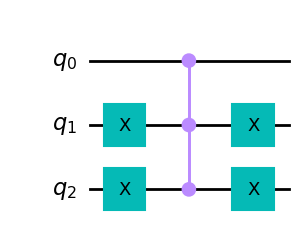

In [7]:

q, c, qc = quantum_initialization(3)

qc.x(1) 

qc.x(2)

qc.ccz(1, 2, 0)

qc.x(1)

qc.x(2)

qc.draw('mpl')

Now that our circuit is made let us apply it to our basis states

In [8]:
basis = ["000", "001", "010", "011", "100", "101", "110", "111"]

for index in basis:

    state = Statevector.from_label(index)

    state.evolve(qc).draw(output='latex')

We can also see it in matrix form using a simulation

The way you perform simulations is by calling a backend and then transpiling the circuit

In [9]:
backend = Aer.get_backend('unitary_simulator')
job = backend.run(transpile(qc, backend))
result = job.result().get_unitary(qc, decimals=3)

array_to_latex(result, prefix="\\text{U = }")

<IPython.core.display.Latex object>

# Measuring

We move on to a more complex task. In PSET8 there is a gate that allows us to measure the overlap between a state a and a state b. Let us actually calculate it.

To actually do this we generate random states for the second and third qubits.

Then we pass those qubits through the circuit and measure

Then we analyze the histogram

Then we are able to actually compute the overlap!

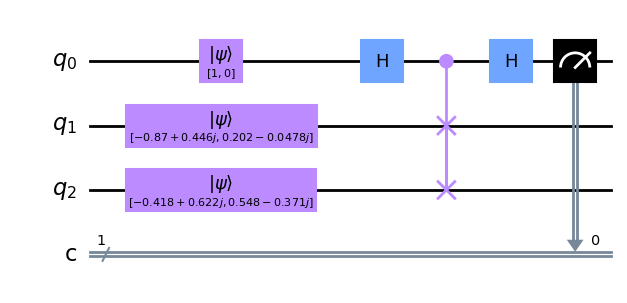

In [10]:
from qiskit.quantum_info import random_statevector
q, c, qc = quantum_initialization(3, 1)

state_a = random_statevector(2)

state_b = random_statevector(2)

qc.initialize([1, 0], 0)
qc.initialize(state_a, 1)
qc.initialize(state_b, 2)

qc.h(0)
qc.cswap(0, 1, 2)
qc.h(0)
qc.measure(0, 0)

qc.draw('mpl')

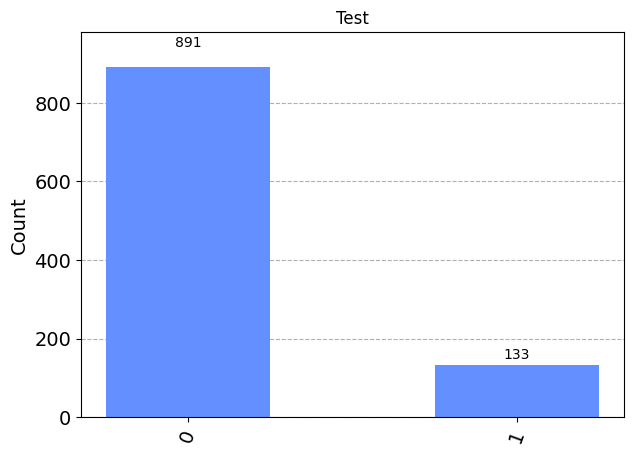

In [11]:
simulator = Aer.get_backend('aer_simulator')
circ = transpile(qc, simulator)

result = simulator.run(qc).result()
counts = result.get_counts(qc)

plot_histogram(counts, title='Test')

In [12]:
def overlap(runs):
    i = 0
    while i < runs:
        q, c, qc = quantum_initialization(3, 1)

        state_a = random_statevector(2)

        state_b = random_statevector(2)

        actual_prob = 0.5 * ( 1 + np.abs((state_a.inner(state_b))) ** 2)

        qc.initialize([1, 0], 0)
        qc.initialize(state_a, 1)
        qc.initialize(state_b, 2)

        qc.h(0)
        qc.cswap(0, 1, 2)
        qc.h(0)
        qc.measure(0, 0)

        circ = transpile(qc, simulator)

        result = simulator.run(qc).result()
        counts = result.get_counts(qc)

        measured_prob =  counts.get('0') / (counts.get('0') + counts.get('1'))

        print("Actual prob: " + str(actual_prob) + ", Measured prob: " + str(measured_prob) + ", Difference: " + str(np.abs(actual_prob-measured_prob)))

        i = i + 1

In [13]:
overlap(10)

Actual prob: 0.9402519364314925, Measured prob: 0.9404296875, Difference: 0.00017775106850748124
Actual prob: 0.5590388739048908, Measured prob: 0.5673828125, Difference: 0.00834393859510918
Actual prob: 0.8020738424900792, Measured prob: 0.79296875, Difference: 0.00910509249007918
Actual prob: 0.9867989304433107, Measured prob: 0.9833984375, Difference: 0.0034004929433106845
Actual prob: 0.9811272623900116, Measured prob: 0.978515625, Difference: 0.0026116373900115786
Actual prob: 0.7045037696395541, Measured prob: 0.7353515625, Difference: 0.03084779286044592
Actual prob: 0.8289816029682218, Measured prob: 0.8291015625, Difference: 0.00011995953177823537
Actual prob: 0.958448099068357, Measured prob: 0.9697265625, Difference: 0.01127846343164296
Actual prob: 0.7950679347621884, Measured prob: 0.78125, Difference: 0.0138179347621884
Actual prob: 0.5026046713854246, Measured prob: 0.51953125, Difference: 0.01692657861457536


## Advanced Algorithms

Let's try and make the Deutsch algorithm given in class.

We want to know if given $f: {0,1} \to {0,1}$ we can determine if it is constant by just calling it once.

We begin with the qubit $\ket{0}\ket{1}$

We start by making the constant oracle

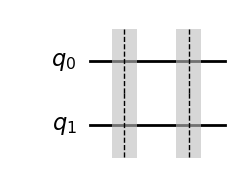

In [14]:
n = 1

const_orac = QuantumCircuit(n + 1)

const_orac.barrier()
output = np.random.randint(2)
if output == 1:
    const_orac.x(n)
const_orac.barrier()


const_orac.draw('mpl')

To make a balanced oracle we have to decide which inputs give 0 and which inputs give 1 with the guarantee that it is balanced. 

We could just make A balanced oracle representing A function f. But there are many balanced functions so it makes sense to have many oracles (generalization)

For n = 1 we only have two options, either $f(0) = 0$ and $f(1) = 1$ or $f(0) = 1$ and $f(1) = 0$

We can use X gates together with CNOT for every control qubit on the register make such functions

Let's make both



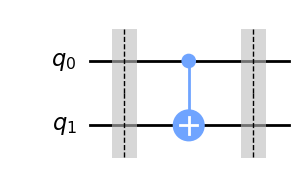

In [15]:
balanced_orac1 = QuantumCircuit(n + 1)
balanced_orac1.barrier()
balanced_orac1.cnot(0, 1)
balanced_orac1.barrier()
balanced_orac1.draw('mpl')

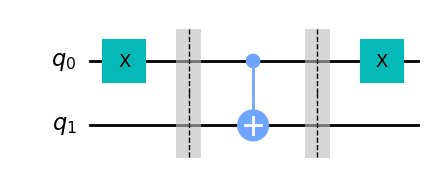

In [16]:
balanced_orac2 = QuantumCircuit(n + 1)
balanced_orac2.x(0)
balanced_orac2.barrier()
balanced_orac2.cnot(0, 1)
balanced_orac2.barrier()
balanced_orac2.x(0)
balanced_orac2.draw('mpl')

Now that we have our three oracles let's put the algorithm together.

The first step is to initialize the first qubit to the $\ket{+}$ state and the second qubit to the $\ket{-}$ state. Then we apply our oracle

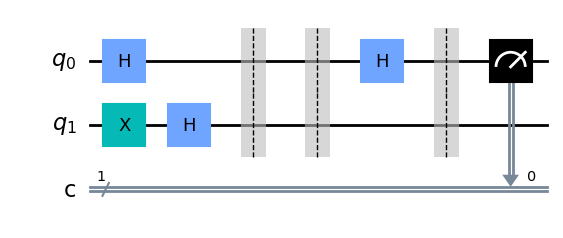

In [17]:
dj_qc = QuantumCircuit(n + 1, n)

dj_qc.h(0)

dj_qc.x(1)
dj_qc.h(1)

dj_qc = dj_qc.compose(const_orac)

dj_qc.h(0)
dj_qc.barrier()

dj_qc.measure(0, 0)
dj_qc.draw('mpl')



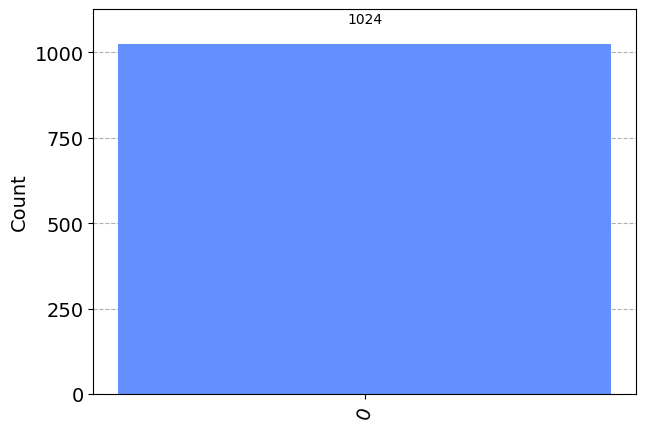

In [18]:
circ = transpile(dj_qc, simulator)

result = simulator.run(dj_qc).result()
counts = result.get_counts(dj_qc)

plot_histogram(counts)

Let's do the same for our balanced oracles

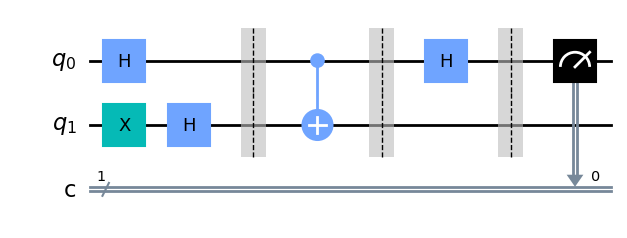

In [19]:
dj_qc = QuantumCircuit(n + 1, n)

dj_qc.h(0)

dj_qc.x(1)
dj_qc.h(1)

dj_qc = dj_qc.compose(balanced_orac1)

dj_qc.h(0)
dj_qc.barrier()

dj_qc.measure(0, 0)
dj_qc.draw('mpl')

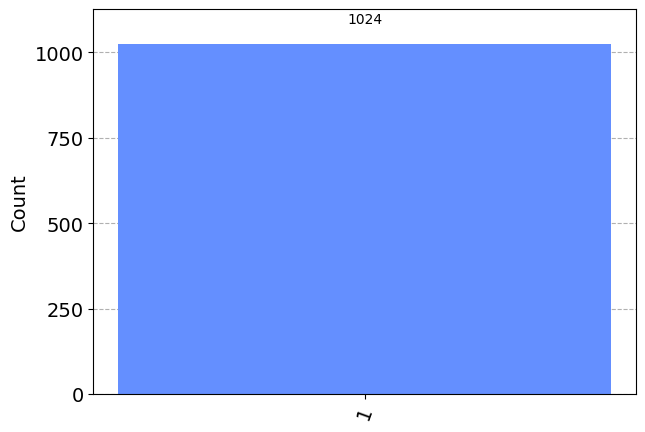

In [20]:
circ = transpile(dj_qc, simulator)

result = simulator.run(dj_qc).result()
counts = result.get_counts(dj_qc)

plot_histogram(counts)

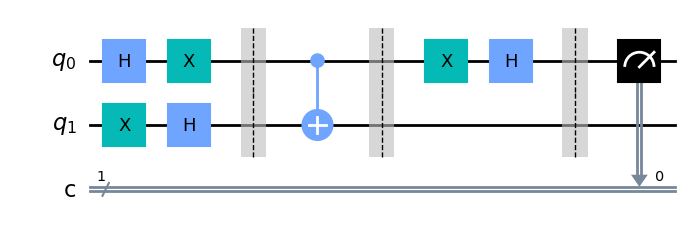

In [21]:
dj_qc = QuantumCircuit(n + 1, n)

dj_qc.h(0)

dj_qc.x(1)
dj_qc.h(1)

dj_qc = dj_qc.compose(balanced_orac2)

dj_qc.h(0)
dj_qc.barrier()

dj_qc.measure(0, 0)
dj_qc.draw('mpl')

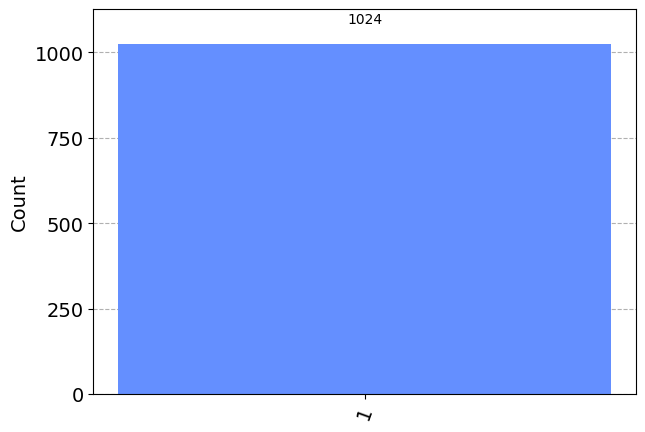

In [22]:
circ = transpile(dj_qc, simulator)

result = simulator.run(dj_qc).result()
counts = result.get_counts(dj_qc)

plot_histogram(counts)

Now let's generalize this algorithm

balanced


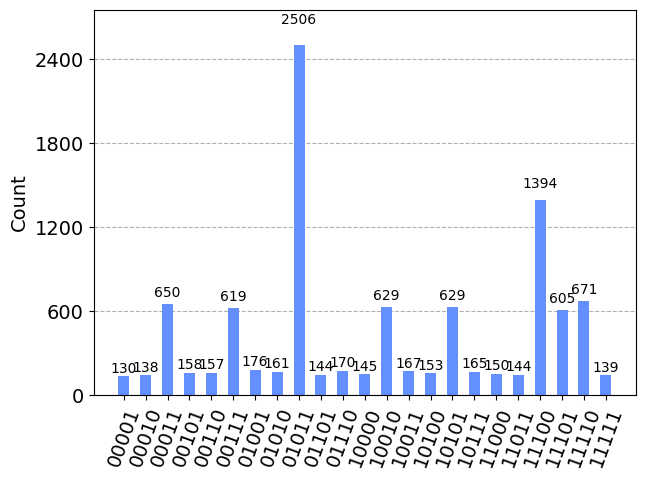

In [218]:
import random as rand
from qiskit.extensions import UnitaryGate
# Define global size of registry

def oracle(n):
    
    N = 2 ** n

    indexes = list(np.arange(N))

    U = np.identity(N)

    type = rand.choice(["constant", "balanced"])

    if type == "constant":

        type = rand.choice(["f(x)=0", "f(x)=1"])

        if type == "f(x)=1":

            U = U * -1
    
    if type == "balanced":

        for i in range(int(N/2)):
            ind=rand.choice(indexes)
            U[ind][ind] = -1
            indexes.remove(ind)
    
    return U, type

def dj_algorithm(oracle):

    n = int(np.log2(np.size(oracle[0])))

    dj = QuantumCircuit(n + 1, n)

    dj.x(n)
    dj.h(n)

    for i in range(n):
        dj.h(i)
    
    dj.unitary(oracle, range(n))

    for i in range(n):
        dj.h(i)
    
    for i in range(n):
        dj.measure(i,i)
    
    return dj

U, type = oracle(5)     
print(type)
dj = dj_algorithm(U)

circ = transpile(dj, simulator)
result = simulator.run(circ, shots=10000).result()
counts = result.get_counts(circ)

plot_histogram(counts)


# Grover's Algorithm

Let's try to make Grover's Algorithm

We start by making the Grover's iterator. In the original text it is made up of two gates: the Oracle and the Amplifier. Because we need to "make" the Oracle, the iterator will also take the solutions indexes as a parameter.

In the original problem we know what the Oracle does to the solutions but we don't know its inner workings. To simulate this we take  the $2^n$ dimensional identity matrix and multiplying the elements whose indexes are solutions by $-1$. The "not knowing" of the solutions comes from the fact that they will be randomly generated.

The amplifier part is pretty straightforward since it is just applying the gates described in the algorithm.



In [26]:

def grover_G(n, solutions):

    qc = QuantumCircuit(n)

    # Oracle
    U = np.identity(2 ** n)
    for ind in solutions:
            U[ind][ind] = U[ind][ind] * -1

    qc.unitary(U, range(n))

    # Amplifier
    for qubit in range(n):
        qc.h(qubit)
        qc.x(qubit)
    
    # Controlled Z can be decomposed into hadamard and toffoli
    qc.h(n - 1)
    qc.mct(list(range(n-1)), n - 1)
    qc.h(n - 1)

    for qubit in range(n):
        qc.x(qubit)
        qc.h(qubit)
    
    # Gate Creation
    G_gate = qc.to_gate()
    G_gate.name = "G"

    return G_gate

The next step is to actually make the actual algorithm. The algorithm should take in three parameters: the length of the list N, the actual list of solutions and the number of iterations we want to run. The length of the list is needed because we need to know the size of the register for our quantum circuit. The size should be be $\lceil log_2(N) \rceil$ in order to store the indexes properly. Then we create the registry, add Hadamard Gates to each qubit and apply the Grover's Iterator to the qubits "iter" times.

In the following cell we can test freely for some number N and a list of solutions.

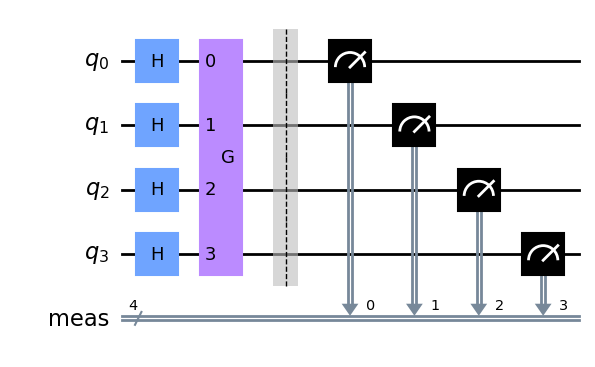

In [27]:
# Define global list size
N = 10

# We work with normal indexes. It's easier this way (0 ... N-1)
solutions = [1,3,4, 5]

def grover(N, solutions, iter):

    n = int(np.ceil(np.log2(N)))

    qc = QuantumCircuit(n)

    for qubit in range(n):
        qc.h(qubit)
    for i in range(iter):
        qc.append(grover_G(n, solutions), range(n))
    qc.measure_all()
    return qc

qc = grover(N, solutions, 1)
qc.draw('mpl')

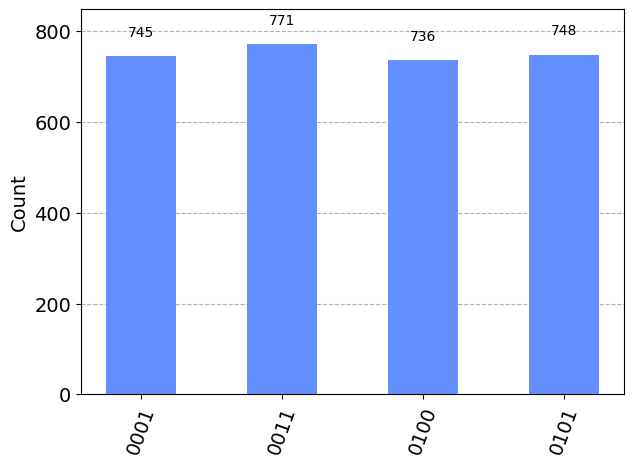

In [28]:
transpiled_grover_circuit = transpile(qc, simulator)
qobj = assemble(transpiled_grover_circuit)
results = simulator.run(qobj, shots = 3000).result()
counts = results.get_counts()
plot_histogram(counts)

Now we want our Grover's to have the best performance possible:

If the solutions make up most of the list then we double the size of the list

We calculate best number of iterations (given by a formula)

In [29]:
import matplotlib.pyplot as plt

def best_grover_n(N, solutions):

    M = len(solutions)

    if M >= N / 2:
        N = 2 * N

    iter = int(np.floor((np.pi / 4) * np.sqrt(N/M)) )

    return grover(N, solutions, iter)


qc = best_grover_n(N, solutions)

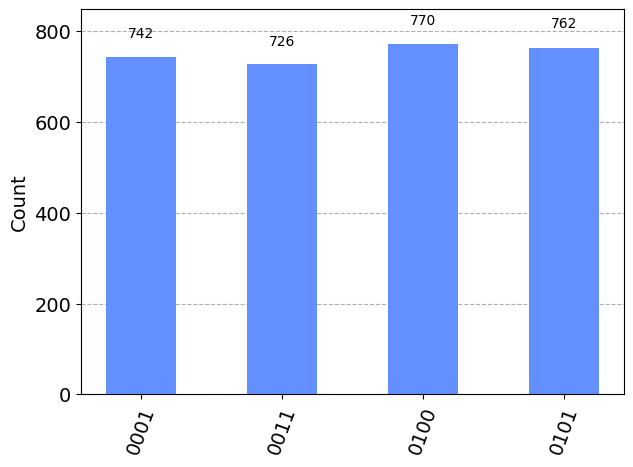

In [30]:
transpiled_grover_circuit = transpile(qc, simulator)
qobj = assemble(transpiled_grover_circuit)
results = simulator.run(qobj, shots = 3000).result()
counts = results.get_counts()
plot_histogram(counts)

Lastly, we need to make a function that given the list size N spits out random solutions. It should also allow for the "not knowing" of the number of solutions. In that case we just make up a random number M ranging from 0 to N

To confirm our algorithm is working we also make a function that prints those solutions in binary format.

In [31]:
def make_solutions(N, M = 'r'):

    solutions = []

    indexes = list(range(N))

    if M == 'r':
        # Gives number of solutions
        M = rand.randint(1, N)
    
    # Making M random solutions
    for i in range(M):
        rand_ind = rand.choice(indexes)
        solutions.append(rand_ind)
        indexes.remove(rand_ind)
    
    return solutions

def print_sol(solutions):
    bin_sol = []
    for sol in solutions:
        bin_sol.append('{0:b}'.format(sol))
    print(bin_sol)

solutions = make_solutions(N, 4)
print_sol(solutions)
grovers = best_grover_n(N, solutions)

['1001', '100', '1', '101']


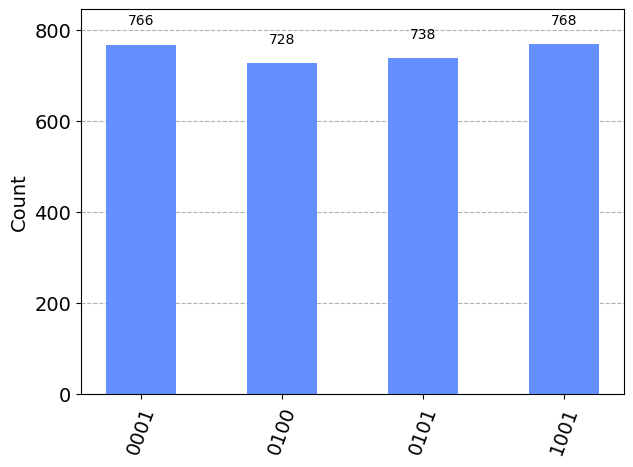

In [32]:

transpiled_grover_circuit = transpile(grovers, simulator)
qobj = assemble(transpiled_grover_circuit)
results = simulator.run(qobj, shots = 3000).result()
counts = results.get_counts()
plot_histogram(counts)

We can run our circuit in real devices. For that we need to get a provider, a device and a backend. There are some parameters that need to match the size of our registry

In [33]:
N = 5

solutions = make_solutions(N, 2)
grovers = best_grover_n(N, solutions)

In [34]:
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy

size = np.ceil(np.log2(N))

provider = IBMQ.get_provider("ibm-q")
device = least_busy(provider.backends(filters=lambda x: int(x.configuration().n_qubits) >= size and 
                                   not x.configuration().simulator and x.status().operational==True))

backend = least_busy(provider.backends(filters=lambda x: int(x.configuration().n_qubits) >= size and 
                                   not x.configuration().simulator and x.status().operational==True))

IBMQProviderError: 'No provider matches the specified criteria: hub = ibm-q, group = None, project = None'

Then we run the device!

In [ ]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor
transpiled_grover_circuit = transpile(grovers, device, optimization_level=3)
job = device.run(transpiled_grover_circuit)

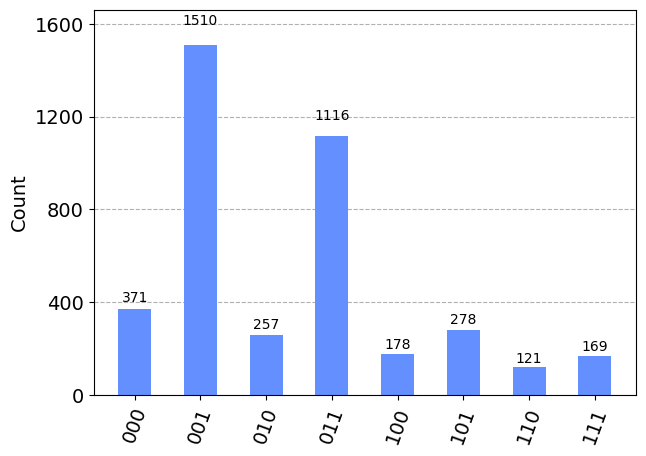

In [ ]:
# Get the results from the computation
results = job.result()
answer = results.get_counts(grovers)
plot_histogram(answer)